In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import statsmodels.tsa.stattools as stt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report

import tensorflow as tf
import joblib

import data_processor
import lstm_architectures

In [2]:
sns.set_style('darkgrid')

plt.rcParams['axes.titlepad'] = 5
plt.rcParams['axes.titlesize'] = 15

## Loading in the Data

In [3]:
df = pd.read_csv('Data/original_data.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df.index = df.index.rename('Date')

oil_df = df[df.columns[:10]]
main_df = df[df.columns[:9]]

In [4]:
df.describe()

,inflation_rate,unemployment_rate,federal_funds_rate,market_yield_10_rate,ppi_rate,gdp_pc1,gdp_invest_pc1,sp500_yoy,consumer_senti_pc1,oil_price_pc1,recessions
count,647.000000,647.000000,647.00000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,4.039918,6.130603,4.90660,6.030216,3.905978,2.726335,3.940979,0.085262,0.394984,12.431637,0.131376
std,2.938396,1.703845,3.91659,3.139814,6.095711,2.317396,9.554729,0.161618,13.863480,41.607284,0.338072
min,-1.958760,3.400000,0.05000,0.620000,-16.058390,-7.528460,-26.088120,-0.425088,-41.520470,-74.083930,0.000000
25%,2.108595,4.900000,1.42500,3.545000,0.493705,1.665040,-1.441935,-0.005681,-7.377300,-8.863300,0.000000
50%,3.193960,5.800000,4.99000,5.980000,3.568320,2.858940,4.705050,0.101513,0.000000,5.129980,0.000000
75%,5.035415,7.200000,6.91000,7.885000,6.366895,4.187830,9.654415,0.192164,7.367725,24.484180,0.000000
max,14.592270,14.800000,19.10000,15.320000,23.440860,11.950270,39.190670,0.526386,47.582210,272.930510,1.000000


In [5]:
adf_test_dict = {'Variable': [], 'ADF-Statistic': [], 'P-Value': [],
                 'Used Lag': [], 'Nobs': [], '1%': [], '5%': [], 
                 '10%': [], 'Stationary': []}

for column in df.columns[:10]:
    adf_test = stt.adfuller(df[column])
    adf_test_dict['Variable'].append(column)
    adf_test_dict['ADF-Statistic'].append(adf_test[0].round(4))
    adf_test_dict['P-Value'].append(adf_test[1].round(4))
    adf_test_dict['Used Lag'].append(adf_test[2])
    adf_test_dict['Nobs'].append(adf_test[3])
    adf_test_dict['1%'].append(adf_test[4]['1%'].round(4))
    adf_test_dict['5%'].append(adf_test[4]['5%'].round(4))
    adf_test_dict['10%'].append(adf_test[4]['10%'].round(4))

    if adf_test[1] < 0.05:
        adf_test_dict['Stationary'].append('Yes')
    else:
        adf_test_dict['Stationary'].append('No')

adf_test_df = pd.DataFrame.from_dict(adf_test_dict)
adf_test_df

,Variable,ADF-Statistic,P-Value,Used Lag,Nobs,1%,5%,10%,Stationary
0,inflation_rate,-2.9505,0.0398,15,631,-3.4408,-2.8661,-2.5692,Yes
1,unemployment_rate,-3.3240,0.0138,2,644,-3.4405,-2.8660,-2.5692,Yes
2,federal_funds_rate,-2.5860,0.0959,17,629,-3.4408,-2.8661,-2.5692,No
3,market_yield_10_rate,-1.4700,0.5483,12,634,-3.4407,-2.8661,-2.5692,No
4,ppi_rate,-5.1158,0.0000,15,631,-3.4408,-2.8661,-2.5692,Yes
5,gdp_pc1,-4.5637,0.0002,12,634,-3.4407,-2.8661,-2.5692,Yes
6,gdp_invest_pc1,-4.7696,0.0001,12,634,-3.4407,-2.8661,-2.5692,Yes
7,sp500_yoy,-4.9281,0.0000,13,633,-3.4407,-2.8661,-2.5692,Yes
8,consumer_senti_pc1,-5.4567,0.0000,16,630,-3.4408,-2.8661,-2.5692,Yes
9,oil_price_pc1,-5.3638,0.0000,12,634,-3.4407,-2.8661,-2.5692,Yes


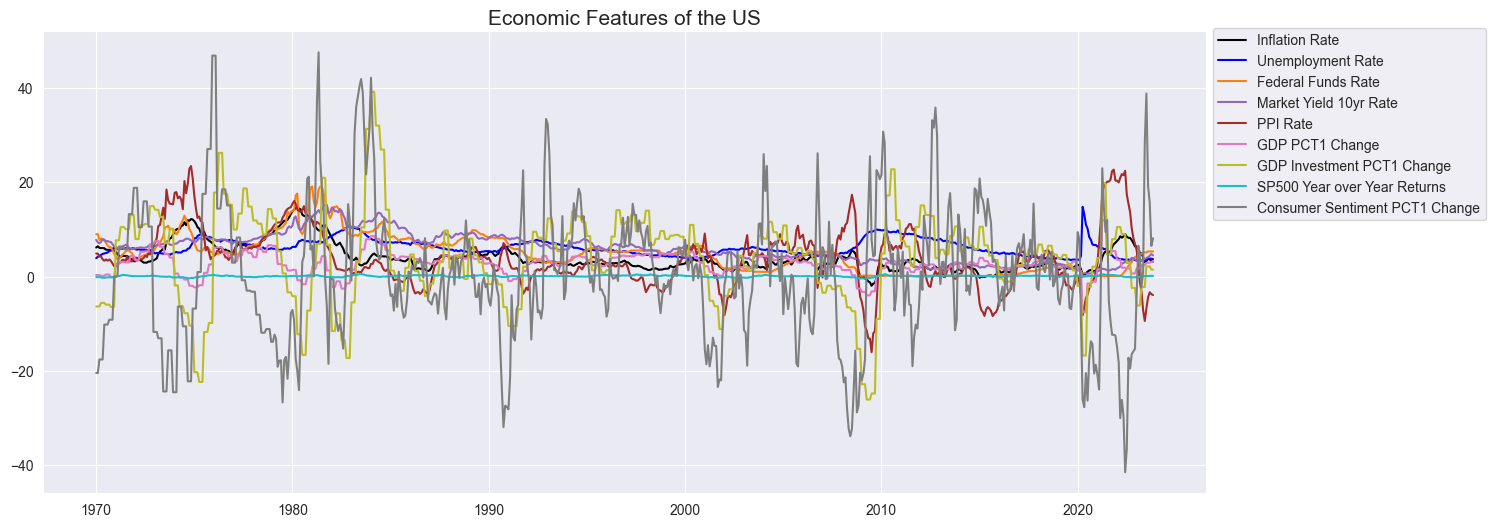

In [6]:
plt.figure(figsize=(15, 6), dpi=100)
colors_nice = ['black', 'blue', 'C1', 'C4', 'brown', 'C6', 'C8', 'C9', 'C7']
labels = ['Inflation Rate', 'Unemployment Rate', 'Federal Funds Rate', 
          'Market Yield 10yr Rate', 'PPI Rate', 'GDP PCT1 Change', 
          'GDP Investment PCT1 Change', 'SP500 Year over Year Returns', 
          'Consumer Sentiment PCT1 Change']

for i, col in enumerate(main_df.columns):
    plt.plot(main_df.index, main_df[col], label=labels[i], color=colors_nice[i])

plt.title('Economic Features of the US')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.799))
plt.show()

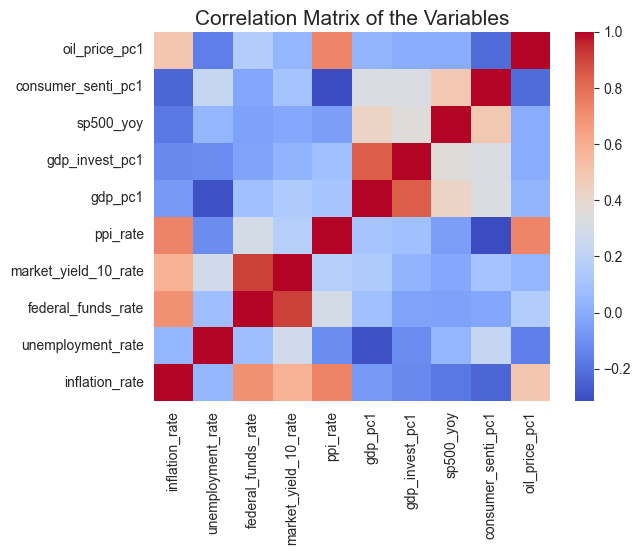

In [7]:
df_corr = oil_df.corr()
plt.figure(dpi=100)
fig = sns.heatmap(df_corr, cmap='coolwarm')
fig.invert_yaxis()
plt.title('Correlation Matrix of the Variables')
plt.show()

## Hidden Markov Model

In [8]:
hmm_model = joblib.load(f'Models/hmm_forecasts/hmm_model.pkl')

hidden_states = hmm_model.predict(main_df)
means = hmm_model.means_

hmm_df = main_df.copy()

for i in range(len(main_df.columns)):
    hmm_df[f'means_{i}'] = means[hidden_states, i]

hmm_df['hidden_states'] = hidden_states

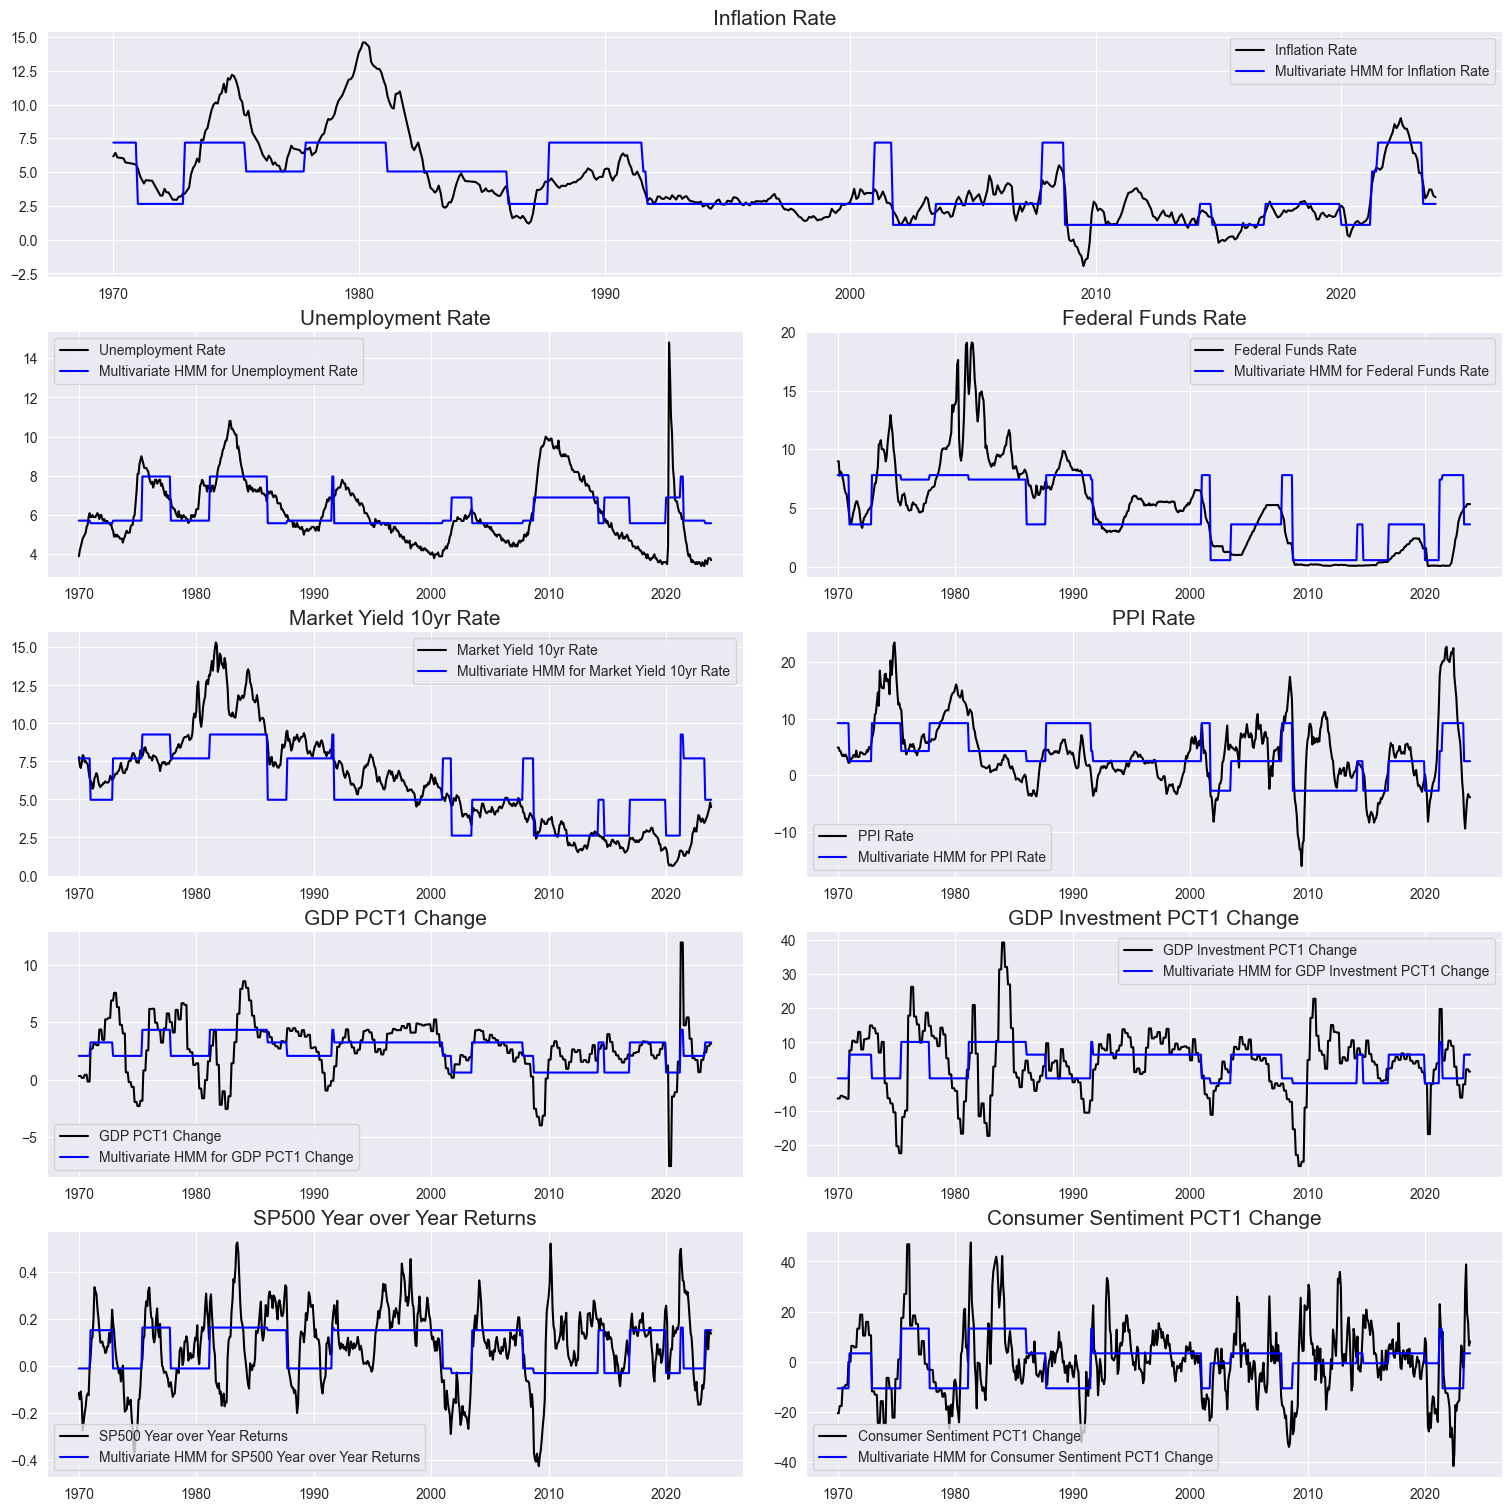

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15), dpi=100)
gs = GridSpec(5, 2, figure=fig)

data_columns = hmm_df.columns[:9]
hmm_columns = hmm_df.columns[9:18]

ax_inflation = fig.add_subplot(gs[0, 0:2])
ax_inflation.plot(hmm_df[data_columns[0]], color='black', label='Inflation Rate')
ax_inflation.plot(hmm_df[hmm_columns[0]], color='blue', label=f'Multivariate HMM for {labels[0]}')
ax_inflation.set_title(labels[0])
ax_inflation.legend()

for i, (data_col, hmm_col, title) in enumerate(zip(data_columns[1:], hmm_columns[1:], labels[1:])):
    row = i // 2 + 1
    col = i % 2

    ax = fig.add_subplot(gs[row, col])
    ax.plot(hmm_df[data_col], color='black', label=f'{title}')
    ax.plot(hmm_df[hmm_col], color='blue', label=f'Multivariate HMM for {title}')
    ax.set_title(title)
    ax.legend()

plt.show()

In [10]:
print(f'Transmission Matrix Generated:\n{hmm_model.transmat_.round(3)}\n\n'
      f'Start Probabilities Generated:\n{hmm_model.startprob_.round(3)}\n\n'
      f'Stationary Distributions: \n{hmm_model.get_stationary_distribution().round(3)}')

Transmission Matrix Generated:
[[0.975 0.003 0.011 0.011]
 [0.03  0.928 0.042 0.   ]
 [0.012 0.022 0.955 0.011]
 [0.041 0.02  0.    0.939]]

Start Probabilities Generated:
[0. 0. 1. 0.]

Stationary Distributions: 
[0.487 0.133 0.247 0.133]


### HMM to Recessions

In [11]:
hs_original = list(hmm_df['hidden_states'])
hs_transform = [1]

for i in range(1, len(hs_original)):
    if hs_original[i] == 0 and hs_original[i - 1] == 0:
        hs_transform.append(0)
    elif hs_original[i] > hs_original[i - 1]:
        hs_transform.append(1)
    elif hs_original[i] == hs_original[i - 1]:
        hs_transform.append(hs_transform[len(hs_transform) - 1])
    else:
        hs_transform.append(0)

In [12]:
recession_df = pd.DataFrame()
recession_df['actual_recessions'] = df['recessions']
recession_df['hidden_states'] = hmm_df['hidden_states']
recession_df['hidden_states_transformed'] = hs_transform

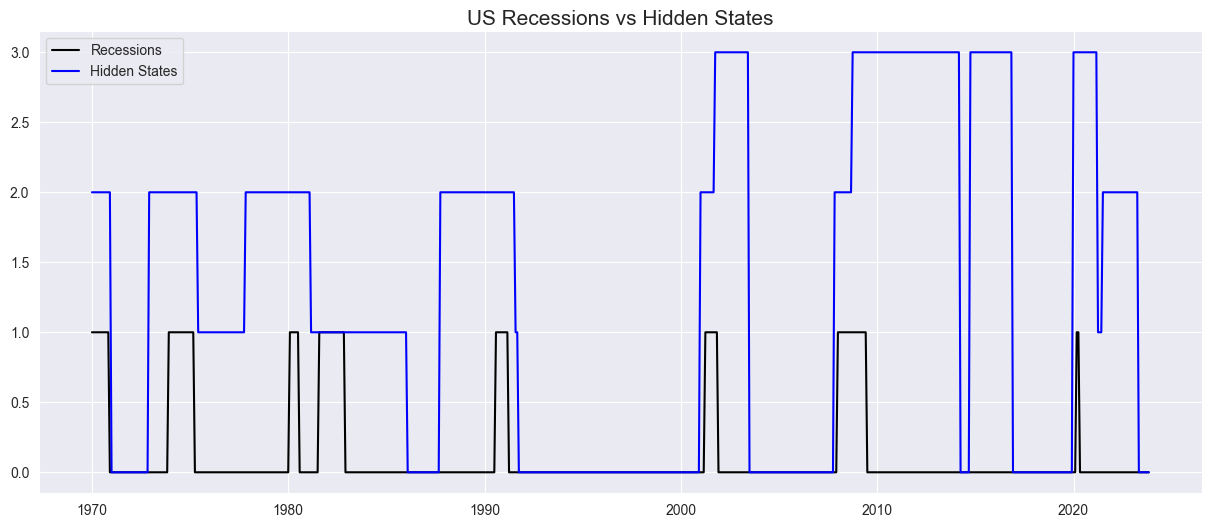

In [13]:
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(recession_df['actual_recessions'], color='black', label='Recessions')
plt.plot(recession_df['hidden_states'], color='blue', label='Hidden States')
plt.title('US Recessions vs Hidden States')
plt.legend()

plt.show()

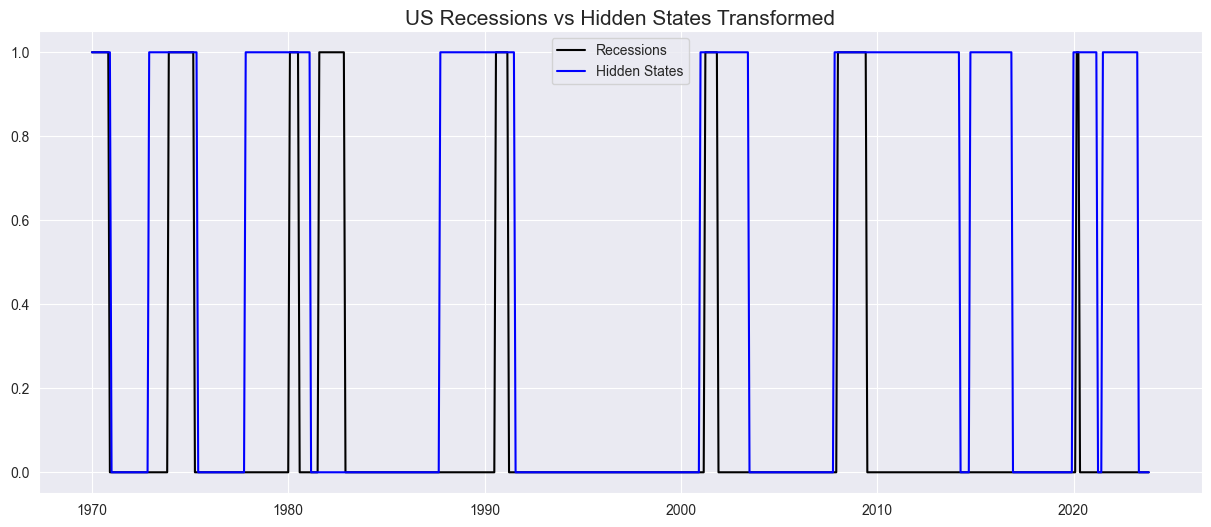

In [14]:
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(recession_df['actual_recessions'], color='black', label='Recessions')
plt.plot(recession_df['hidden_states_transformed'], color='blue', label='Hidden States')
plt.title('US Recessions vs Hidden States Transformed')
plt.legend()

plt.show()

In [15]:
print(classification_report(recession_df['actual_recessions'], recession_df['hidden_states_transformed']))

              precision    recall  f1-score   support

         0.0       0.95      0.59      0.73       562
         1.0       0.23      0.81      0.36        85

    accuracy                           0.62       647
   macro avg       0.59      0.70      0.55       647
weighted avg       0.86      0.62      0.68       647



### Testing Oil Data

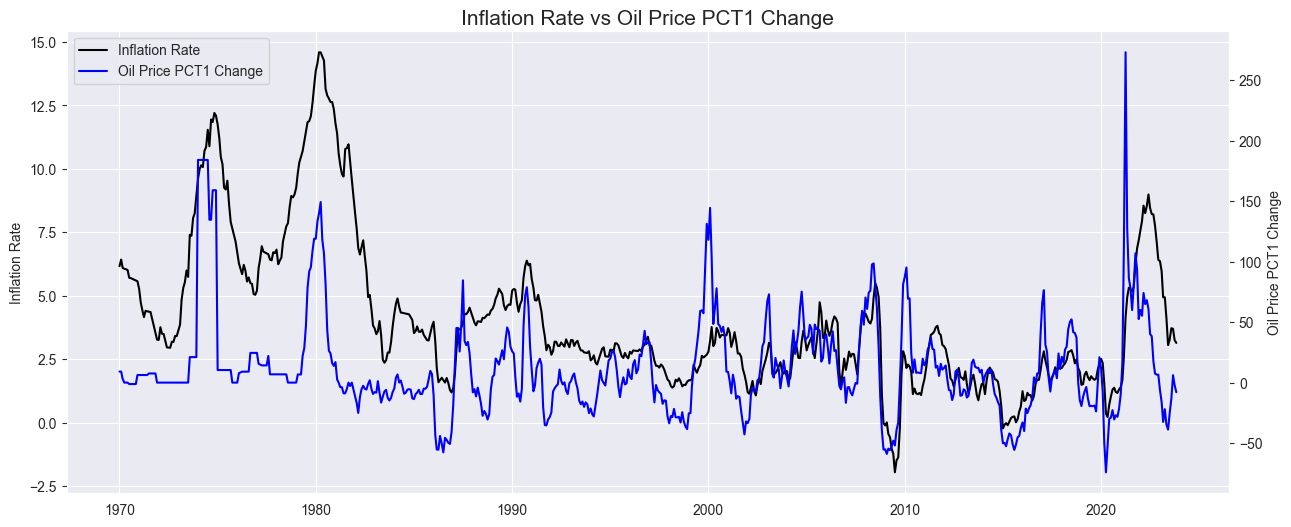

In [16]:
fig, ax1 = plt.subplots(figsize=(15, 6), dpi=100)

ax1.plot(oil_df['inflation_rate'], color='black', label='Inflation Rate')
ax1.set_ylabel('Inflation Rate')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(oil_df['oil_price_pc1'], color='blue', label='Oil Price PCT1 Change')
ax2.set_ylabel('Oil Price PCT1 Change')
ax2.tick_params(axis='y')
ax2.grid(False)

plt.title("Inflation Rate vs Oil Price PCT1 Change")
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

In [17]:
hmm_oil_model = joblib.load(f'Models/hmm_forecasts/hmm_oil_model.pkl')

hidden_states_oil = hmm_oil_model.predict(oil_df)
recession_df['hidden_states_oil'] = hidden_states_oil

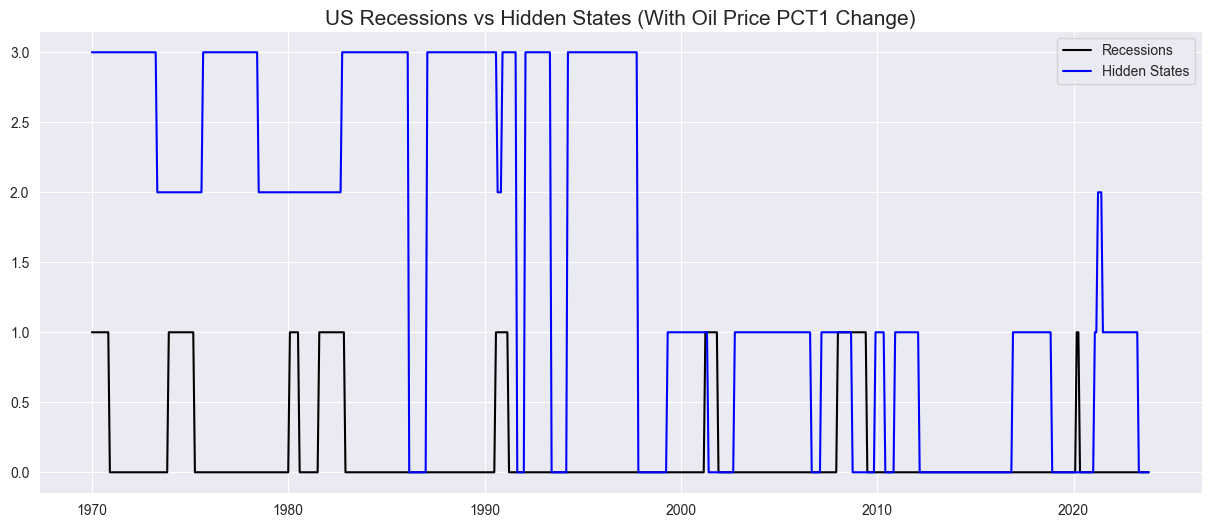

In [18]:
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(recession_df['actual_recessions'], color='black', label='Recessions')
plt.plot(recession_df['hidden_states_oil'], color='blue', label='Hidden States')
plt.title('US Recessions vs Hidden States (With Oil Price PCT1 Change)')
plt.legend()

plt.show()

In [19]:
hmm_df.head()

,inflation_rate,unemployment_rate,federal_funds_rate,market_yield_10_rate,ppi_rate,gdp_pc1,gdp_invest_pc1,sp500_yoy,consumer_senti_pc1,means_0,means_1,means_2,means_3,means_4,means_5,means_6,means_7,means_8,hidden_states
Date,,,,,,,,,,,,,,,,,,,
1970-01-01,6.16246,3.9,8.98,7.79,4.88506,0.32279,-6.34748,-0.114759,-20.46843,7.181569,5.717385,7.799294,7.700506,9.188703,2.070408,-0.476978,-0.00969,-10.534591,2
1970-02-01,6.42458,4.2,8.98,7.24,4.85714,0.32279,-6.34748,-0.140891,-20.46843,7.181569,5.717385,7.799294,7.700506,9.188703,2.070408,-0.476978,-0.00969,-10.534591,2
1970-03-01,6.09418,4.4,7.76,7.07,4.26136,0.32279,-6.34748,-0.107267,-17.59563,7.181569,5.717385,7.799294,7.700506,9.188703,2.070408,-0.476978,-0.00969,-10.534591,2
1970-04-01,6.06061,4.6,8.10,7.39,4.24929,0.16112,-5.58762,-0.151196,-17.59563,7.181569,5.717385,7.799294,7.700506,9.188703,2.070408,-0.476978,-0.00969,-10.534591,2
1970-05-01,6.04396,4.8,7.95,7.91,3.66197,0.16112,-5.58762,-0.272988,-17.59563,7.181569,5.717385,7.799294,7.700506,9.188703,2.070408,-0.476978,-0.00969,-10.534591,2


## Recurrent Neural Network

In [20]:
target_variable = 'inflation_rate'
split = int(0.7 * len(main_df))
time_steps = 24

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [21]:
train_idxs = []
test_idxs = []

for train_index, test_index in tscv.split(main_df[time_steps:]):
    train_idxs.append(train_index)
    test_idxs.append(test_index)

### Original Data

In [22]:
original_df = main_df.copy()
og_predictions = []

In [23]:
tf.keras.utils.set_random_seed(42)

og_X, og_y = data_processor.ins_data_preprocess_cv(original_df, 
                                                   target_variable, 
                                                   time_steps)

for i, (train_index, test_index) in enumerate(tscv.split(og_X)):
    X_train, X_test = og_X[train_index], og_X[test_index]
    y_train, y_test = og_y[train_index], og_y[test_index]

    X_train_s, X_test_s, y_train_s, \
    y_test_s, og_scaler_target = data_processor.data_scaler(X_train, X_test, 
                                                            y_train, y_test)

    og_cv_model = tf.keras.models.load_model(f'Models/cross_validation_forecasts/og_cv_model_{i + 1}')

    y_pred = og_cv_model.predict(X_test_s)
    y_pred_final = og_scaler_target.inverse_transform(y_pred)
    y_test_original = og_scaler_target.inverse_transform(y_test_s.reshape(-1, 1))
    
    print(f"Fold {i + 1}")
    print(lstm_architectures.eval_metrics(y_test_original, y_pred_final))

    og_predictions.append(y_pred_final)

full_og_predictions = list(np.concatenate(og_predictions).flat)

4/4 [==============================] - 0s 3ms/step
Fold 1
Mean Squared Error: 11.58
Mean Absolute Error: 2.93
R²: -0.911

4/4 [==============================] - 0s 3ms/step
Fold 2
Mean Squared Error: 0.486
Mean Absolute Error: 0.597
R²: 0.59

4/4 [==============================] - 0s 3ms/step
Fold 3
Mean Squared Error: 0.49
Mean Absolute Error: 0.549
R²: 0.33

4/4 [==============================] - 0s 4ms/step
Fold 4
Mean Squared Error: 1.08
Mean Absolute Error: 0.74
R²: 0.509

4/4 [==============================] - 0s 5ms/step
Fold 5
Mean Squared Error: 1.631
Mean Absolute Error: 1.008
R²: 0.711



In [24]:
tf.keras.utils.set_random_seed(42)

X_train, X_test, \
y_train, y_test = data_processor.ins_data_preprocess(original_df, 
                                                     target_variable, 
                                                     split,
                                                     time_steps)

X_train_s, X_test_s, \
y_train_s, y_test_s, \
og_scaler_target = data_processor.data_scaler(X_train, X_test,
                                              y_train, y_test)


og_model = tf.keras.models.load_model(f'Models/in_sample_forecasts/og_model')

y_pred = og_model.predict(X_test_s)
y_pred_final = og_scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = og_scaler_target.inverse_transform(y_test_s.reshape(-1, 1))

print(lstm_architectures.eval_metrics(y_test_original, y_pred_final))

6/6 [==============================] - 0s 3ms/step
Mean Squared Error: 1.992
Mean Absolute Error: 0.964
R²: 0.519



### Data with Hidden State as Feature

In [25]:
hidden_hmm_df = hmm_df[['inflation_rate', 'unemployment_rate', 'federal_funds_rate',
                        'market_yield_10_rate', 'ppi_rate', 'gdp_pc1', 'gdp_invest_pc1',
                        'sp500_yoy', 'consumer_senti_pc1', 'hidden_states']]
hidden_hmm_predictions = []

In [26]:
tf.keras.utils.set_random_seed(42)

hidden_hmm_X, hidden_hmm_y = data_processor.ins_data_preprocess_cv(hidden_hmm_df, 
                                                                   target_variable, 
                                                                   time_steps)

for i, (train_index, test_index) in enumerate(tscv.split(hidden_hmm_X)):
    X_train, X_test = hidden_hmm_X[train_index], hidden_hmm_X[test_index]
    y_train, y_test = hidden_hmm_y[train_index], hidden_hmm_y[test_index]

    X_train_s, X_test_s, y_train_s, \
    y_test_s, hidden_scaler_target = data_processor.data_scaler(X_train, X_test, 
                                                                y_train, y_test)

    hidden_cv_model = tf.keras.models.load_model(f'Models/cross_validation_forecasts/hidden_cv_model_{i + 1}')
    
    hidden_y_pred = hidden_cv_model.predict(X_test_s)
    hidden_y_pred_final = hidden_scaler_target.inverse_transform(hidden_y_pred)
    hidden_y_test_original = hidden_scaler_target.inverse_transform(y_test_s.reshape(-1, 1))
    
    print(f"Fold {i + 1}")
    print(lstm_architectures.eval_metrics(hidden_y_test_original, hidden_y_pred_final))

    hidden_hmm_predictions.append(hidden_y_pred_final)

full_hidden_predictions = list(np.concatenate(hidden_hmm_predictions).flat)

4/4 [==============================] - 0s 3ms/step
Fold 1
Mean Squared Error: 11.895
Mean Absolute Error: 3.08
R²: -0.963

4/4 [==============================] - 0s 4ms/step
Fold 2
Mean Squared Error: 1.046
Mean Absolute Error: 0.884
R²: 0.118

4/4 [==============================] - 0s 4ms/step
Fold 3
Mean Squared Error: 0.623
Mean Absolute Error: 0.629
R²: 0.149

4/4 [==============================] - 0s 3ms/step
Fold 4
Mean Squared Error: 0.862
Mean Absolute Error: 0.672
R²: 0.608

4/4 [==============================] - 0s 4ms/step
Fold 5
Mean Squared Error: 0.799
Mean Absolute Error: 0.677
R²: 0.858



In [27]:
tf.keras.utils.set_random_seed(42)

hidden_hmm_X_train, hidden_hmm_X_test, \
hidden_hmm_y_train, hidden_hmm_y_test = data_processor.ins_data_preprocess(hidden_hmm_df, 
                                                                           target_variable, 
                                                                           split, 
                                                                           time_steps)

hidden_hmm_X_train_s, hidden_hmm_X_test_s, \
hidden_hmm_y_train_s, hidden_hmm_y_test_s, \
hidden_scaler_target = data_processor.data_scaler(hidden_hmm_X_train, hidden_hmm_X_test, 
                                                  hidden_hmm_y_train, hidden_hmm_y_test)

hidden_model = tf.keras.models.load_model(f'Models/in_sample_forecasts/hidden_model')

hidden_hmm_y_pred = hidden_model.predict(hidden_hmm_X_test_s)
hidden_hmm_y_pred_final = hidden_scaler_target.inverse_transform(hidden_hmm_y_pred.reshape(-1, 1))
hidden_hmm_y_test_original = hidden_scaler_target.inverse_transform(hidden_hmm_y_test_s.reshape(-1, 1))

print(lstm_architectures.eval_metrics(hidden_hmm_y_test_original, hidden_hmm_y_pred_final))

6/6 [==============================] - 0s 3ms/step
Mean Squared Error: 3.548
Mean Absolute Error: 1.29
R²: 0.144



### Data with Means as Features

In [28]:
means_hmm_df = hmm_df[['inflation_rate', 'unemployment_rate', 'federal_funds_rate',
                       'market_yield_10_rate', 'ppi_rate', 'gdp_pc1', 'gdp_invest_pc1',
                       'sp500_yoy', 'consumer_senti_pc1', 'means_0', 'means_1', 'means_2', 
                       'means_3', 'means_4', 'means_5', 'means_6', 'means_7', 'means_8']]
means_hmm_predictions = []

In [29]:
tf.keras.utils.set_random_seed(42)

means_hmm_X, means_hmm_y = data_processor.ins_data_preprocess_cv(means_hmm_df, 
                                                                 target_variable, 
                                                                 time_steps)

for i, (train_index, test_index) in enumerate(tscv.split(means_hmm_X)):
    X_train, X_test = means_hmm_X[train_index], means_hmm_X[test_index]
    y_train, y_test = means_hmm_y[train_index], means_hmm_y[test_index]

    X_train_s, X_test_s, y_train_s, \
    y_test_s, means_scaler_target = data_processor.data_scaler(X_train, X_test, 
                                                               y_train, y_test)

    means_cv_model = tf.keras.models.load_model(f'Models/cross_validation_forecasts/means_cv_model_{i + 1}')
    
    means_y_pred = means_cv_model.predict(X_test_s)
    means_y_pred_final = means_scaler_target.inverse_transform(means_y_pred)
    means_y_test_original = means_scaler_target.inverse_transform(y_test_s.reshape(-1, 1))
    
    print(f"Fold {i + 1}")
    print(lstm_architectures.eval_metrics(means_y_test_original, means_y_pred_final))

    means_hmm_predictions.append(means_y_pred_final)

full_means_predictions = list(np.concatenate(means_hmm_predictions).flat)

4/4 [==============================] - 0s 3ms/step
Fold 1
Mean Squared Error: 10.044
Mean Absolute Error: 2.728
R²: -0.657

4/4 [==============================] - 0s 3ms/step
Fold 2
Mean Squared Error: 1.125
Mean Absolute Error: 0.891
R²: 0.052

4/4 [==============================] - 0s 3ms/step
Fold 3
Mean Squared Error: 1.152
Mean Absolute Error: 0.786
R²: -0.574

4/4 [==============================] - 0s 4ms/step
Fold 4
Mean Squared Error: 1.223
Mean Absolute Error: 0.794
R²: 0.444

4/4 [==============================] - 0s 3ms/step
Fold 5
Mean Squared Error: 0.903
Mean Absolute Error: 0.716
R²: 0.84



In [30]:
tf.keras.utils.set_random_seed(42)

means_hmm_X_train, means_hmm_X_test, \
means_hmm_y_train, means_hmm_y_test = data_processor.ins_data_preprocess(means_hmm_df, 
                                                                         target_variable, 
                                                                         split, 
                                                                         time_steps)

means_hmm_X_train_s, means_hmm_X_test_s, \
means_hmm_y_train_s, means_hmm_y_test_s, \
means_scaler_target = data_processor.data_scaler(means_hmm_X_train, means_hmm_X_test,
                                                 means_hmm_y_train, means_hmm_y_test)

means_model = tf.keras.models.load_model(f'Models/in_sample_forecasts/means_model')

means_hmm_y_pred = means_model.predict(means_hmm_X_test_s)
means_hmm_y_pred_final = means_scaler_target.inverse_transform(means_hmm_y_pred.reshape(-1, 1))
means_hmm_y_test_original = means_scaler_target.inverse_transform(means_hmm_y_test_s.reshape(-1, 1))

print(lstm_architectures.eval_metrics(means_hmm_y_test_original, means_hmm_y_pred_final))

6/6 [==============================] - 0s 3ms/step
Mean Squared Error: 0.818
Mean Absolute Error: 0.694
R²: 0.803



### All HMM Data

In [31]:
all_hmm_df = hmm_df.copy()
all_hmm_predictions = []

In [32]:
tf.keras.utils.set_random_seed(42)

all_hmm_X, all_hmm_y = data_processor.ins_data_preprocess_cv(all_hmm_df,
                                                             target_variable,
                                                             time_steps)

for i, (train_index, test_index) in enumerate(tscv.split(all_hmm_X)):
    X_train, X_test = all_hmm_X[train_index], all_hmm_X[test_index]
    y_train, y_test = all_hmm_y[train_index], all_hmm_y[test_index]

    X_train_s, X_test_s, y_train_s, \
    y_test_s, all_scaler_target = data_processor.data_scaler(X_train, X_test, 
                                                             y_train, y_test)

    all_cv_model = tf.keras.models.load_model(f'Models/cross_validation_forecasts/all_cv_model_{i + 1}')
    
    all_y_pred = all_cv_model.predict(X_test_s)
    all_y_pred_final = all_scaler_target.inverse_transform(all_y_pred)
    all_y_test_original = all_scaler_target.inverse_transform(y_test_s.reshape(-1, 1))
    
    print(f"Fold {i + 1}")
    print(lstm_architectures.eval_metrics(all_y_test_original, all_y_pred_final))

    all_hmm_predictions.append(all_y_pred_final)

full_all_predictions = list(np.concatenate(all_hmm_predictions).flat)

4/4 [==============================] - 0s 3ms/step
Fold 1
Mean Squared Error: 8.694
Mean Absolute Error: 2.566
R²: -0.435

4/4 [==============================] - 0s 3ms/step
Fold 2
Mean Squared Error: 1.522
Mean Absolute Error: 1.018
R²: -0.283

4/4 [==============================] - 0s 3ms/step
Fold 3
Mean Squared Error: 1.39
Mean Absolute Error: 0.823
R²: -0.901

4/4 [==============================] - 0s 3ms/step
Fold 4
Mean Squared Error: 1.36
Mean Absolute Error: 0.838
R²: 0.382

4/4 [==============================] - 0s 3ms/step
Fold 5
Mean Squared Error: 0.694
Mean Absolute Error: 0.632
R²: 0.877



In [33]:
tf.keras.utils.set_random_seed(42)

all_hmm_X_train, all_hmm_X_test, \
all_hmm_y_train, all_hmm_y_test = data_processor.ins_data_preprocess(all_hmm_df, 
                                                                     target_variable, 
                                                                     split, 
                                                                     time_steps)

all_hmm_X_train_s, all_hmm_X_test_s, \
all_hmm_y_train_s, all_hmm_y_test_s, \
all_scaler_target = data_processor.data_scaler(all_hmm_X_train, all_hmm_X_test,
                                               all_hmm_y_train, all_hmm_y_test)

all_model = tf.keras.models.load_model(f'Models/in_sample_forecasts/all_model')

all_hmm_y_pred = all_model.predict(all_hmm_X_test_s)
all_hmm_y_pred_final = all_scaler_target.inverse_transform(all_hmm_y_pred.reshape(-1, 1))
all_hmm_y_test_original = all_scaler_target.inverse_transform(all_hmm_y_test_s.reshape(-1, 1))

print(lstm_architectures.eval_metrics(all_hmm_y_test_original, all_hmm_y_pred_final))

6/6 [==============================] - 0s 3ms/step
Mean Squared Error: 0.861
Mean Absolute Error: 0.705
R²: 0.792



### In-Sample Plots

In [34]:
in_df_list = [main_df, hidden_hmm_df, means_hmm_df, all_hmm_df]
in_title_list = ['Original Data', 'Hidden States Data', 'Means Data', 'All HMM Data']
in_main_colors = ['C0', 'C1', 'C5', 'C4']

In [35]:
feature_importance_og = np.load(f'Models/integrated_gradients/feature_importance_og.npy')
feature_importance_og_scaled = 1000 * feature_importance_og

feature_importance_hs = np.load(f'Models/integrated_gradients/feature_importance_hs.npy')
feature_importance_hs_scaled = 1000 * feature_importance_hs

feature_importance_means = np.load(f'Models/integrated_gradients/feature_importance_means.npy')
feature_importance_means_scaled = 1000 * feature_importance_means

feature_importance_all_hmm = np.load(f'Models/integrated_gradients/feature_importance_all_hmm.npy')
feature_importance_all_hmm_scaled = 1000 * feature_importance_all_hmm

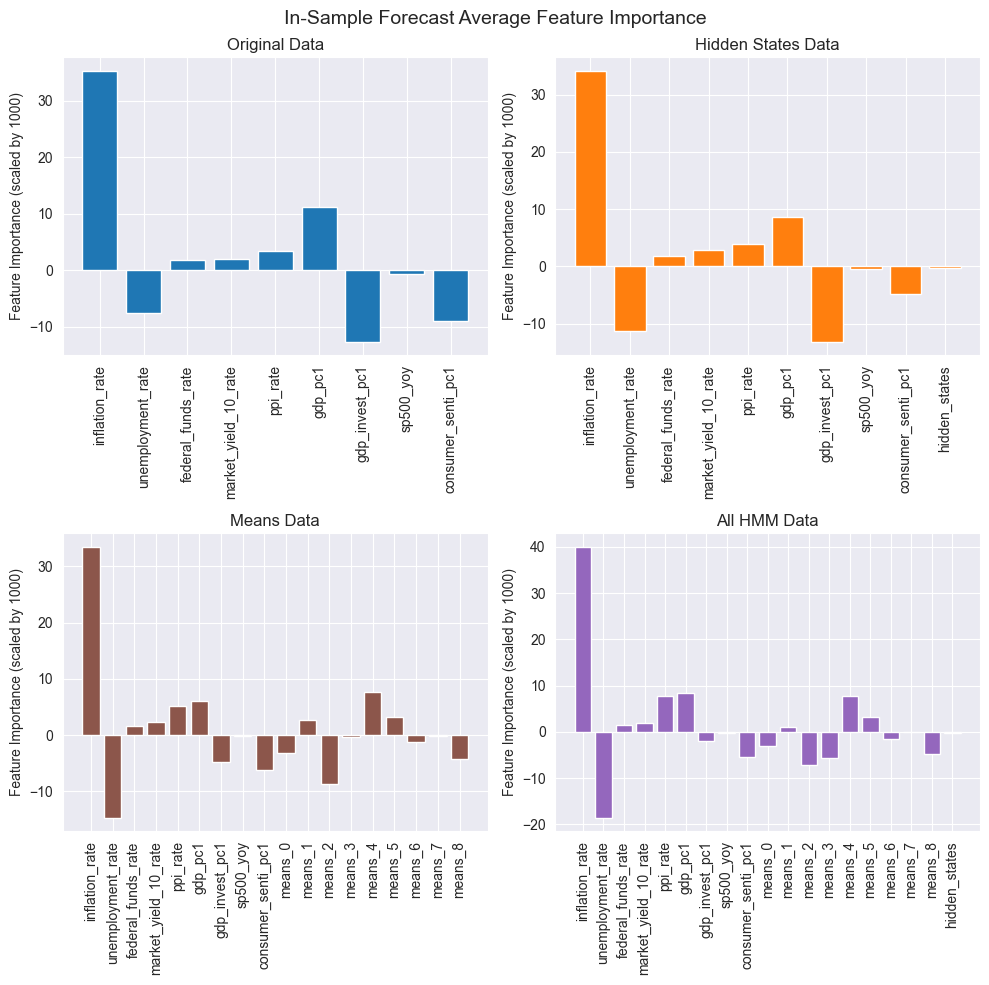

In [36]:
feature_importances_is = [feature_importance_og_scaled, feature_importance_hs_scaled,
                          feature_importance_means_scaled, feature_importance_all_hmm_scaled]

plt.figure(figsize=(10, 10), dpi=100)
for i, (feature_importances, in_df, title, cl) in enumerate(zip(feature_importances_is, in_df_list, in_title_list, in_main_colors), 1):
    plt.subplot(2, 2, i)
    plt.bar(range(len(feature_importances)), feature_importances, color=cl)
    plt.xticks(range(len(feature_importances)), in_df.columns, rotation=90)
    plt.ylabel("Feature Importance (scaled by 1000)")
    plt.title(f"{title}", fontsize=12)

plt.suptitle('In-Sample Forecast Average Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()

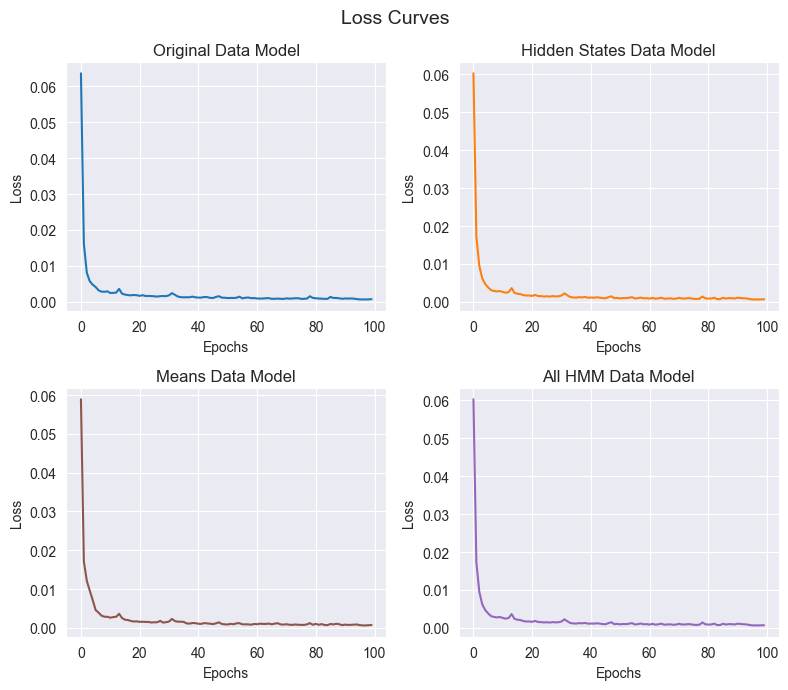

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7), dpi=100)

axs[0, 0].plot(np.load(f'Models/rnn_loss_curves/og_model_history.npy'), color='C0')
axs[0, 0].set_title('Original Data Model', fontsize=12)
axs[0, 1].plot(np.load(f'Models/rnn_loss_curves/hidden_model_history.npy'), color='C1')
axs[0, 1].set_title('Hidden States Data Model', fontsize=12)
axs[1, 0].plot(np.load(f'Models/rnn_loss_curves/means_model_history.npy'), color='C5')
axs[1, 0].set_title('Means Data Model', fontsize=12)
axs[1, 1].plot(np.load(f'Models/rnn_loss_curves/hidden_model_history.npy'), color='C4')
axs[1, 1].set_title('All HMM Data Model', fontsize=12)

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Loss')

plt.suptitle('Loss Curves', fontsize=14)
plt.tight_layout()

plt.show()

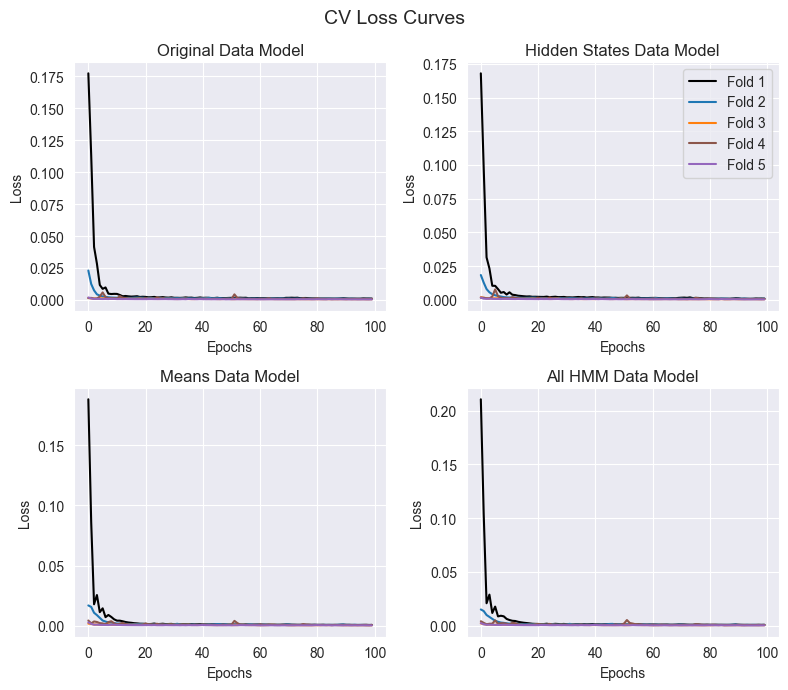

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7), dpi=100)
colors_cv = ['black', 'C0', 'C1', 'C5', 'C4']

axs[0, 0].set_title('Original Data Model', fontsize=12)
axs[0, 1].set_title('Hidden States Data Model', fontsize=12)
axs[1, 0].set_title('Means Data Model', fontsize=12)
axs[1, 1].set_title('All HMM Data Model', fontsize=12)

for i, cl in enumerate(colors_cv):
    axs[0, 0].plot(np.load(f'Models/rnn_loss_curves/og_cv_model_history.npy')[i], color=cl)
    axs[0, 1].plot(np.load(f'Models/rnn_loss_curves/hidden_cv_model_history.npy')[i], color=cl)
    axs[1, 0].plot(np.load(f'Models/rnn_loss_curves/means_cv_model_history.npy')[i], color=cl)
    axs[1, 1].plot(np.load(f'Models/rnn_loss_curves/all_hmm_cv_model_history.npy')[i], color=cl)

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Loss')

fold1_handle = Line2D([0], [0], color='black', label='Fold 1')
fold2_handle = Line2D([0], [0], color='C0', label='Fold 2')
fold3_handle = Line2D([0], [0], color='C1', label='Fold 3')
fold4_handle = Line2D([0], [0], color='C5', label='Fold 4')
fold5_handle = Line2D([0], [0], color='C4', label='Fold 5')

axs[0, 1].legend(handles=[fold1_handle, fold2_handle,
                          fold3_handle, fold4_handle, 
                          fold5_handle])
plt.suptitle('CV Loss Curves', fontsize=14)
plt.tight_layout()

plt.show()

In [39]:
in_sample_forecasts_df = pd.DataFrame({'date': main_df[split + time_steps:].index, 
                                       'original_data_fc': y_pred_final.flatten(),
                                       'hidden_data_fc': hidden_hmm_y_pred_final.flatten(),
                                       'means_data_fc': means_hmm_y_pred_final.flatten(),
                                       'all_hmm_data_fc': all_hmm_y_pred_final.flatten()})

in_sample_forecasts_cv_df = pd.DataFrame({'date': main_df.index[len(main_df) - len(full_og_predictions):], 
                                          'original_data_fc': full_og_predictions,
                                          'hidden_data_fc': full_hidden_predictions,
                                          'means_data_fc': full_means_predictions,
                                          'all_hmm_data_fc': full_all_predictions})

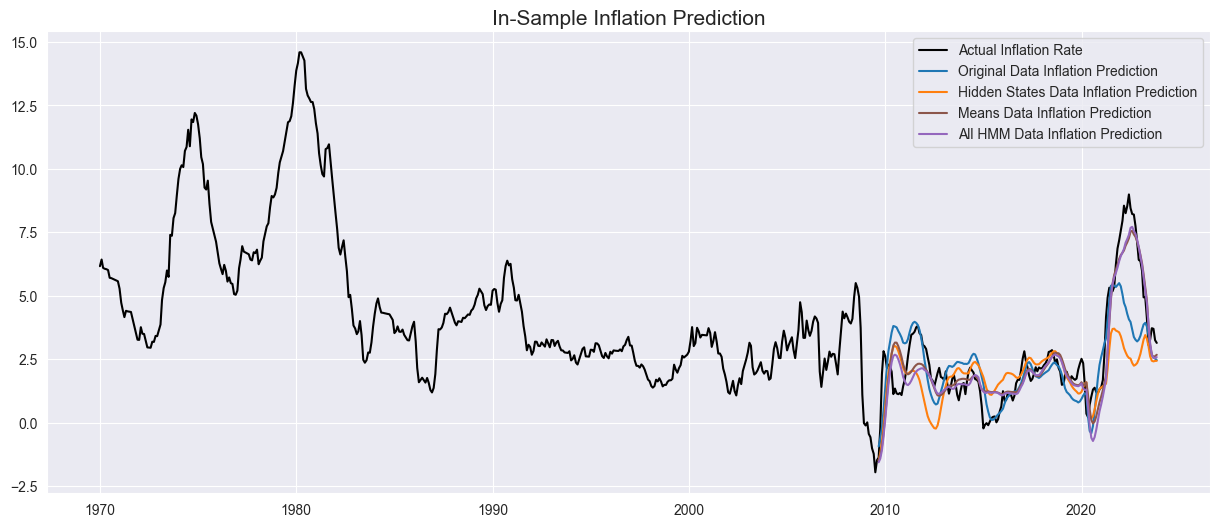

In [40]:
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(main_df.index, main_df['inflation_rate'], color='black', label='Actual Inflation Rate')
plt.plot(in_sample_forecasts_df['date'], in_sample_forecasts_df['original_data_fc'],
         color='C0', label='Original Data Inflation Prediction')
plt.plot(in_sample_forecasts_df['date'], in_sample_forecasts_df['hidden_data_fc'],
         color='C1', label='Hidden States Data Inflation Prediction')
plt.plot(in_sample_forecasts_df['date'], in_sample_forecasts_df['means_data_fc'],
         color='C5', label='Means Data Inflation Prediction')
plt.plot(in_sample_forecasts_df['date'], in_sample_forecasts_df['all_hmm_data_fc'],
         color='C4', label='All HMM Data Inflation Prediction')

plt.title('In-Sample Inflation Prediction')
plt.legend()
plt.show()

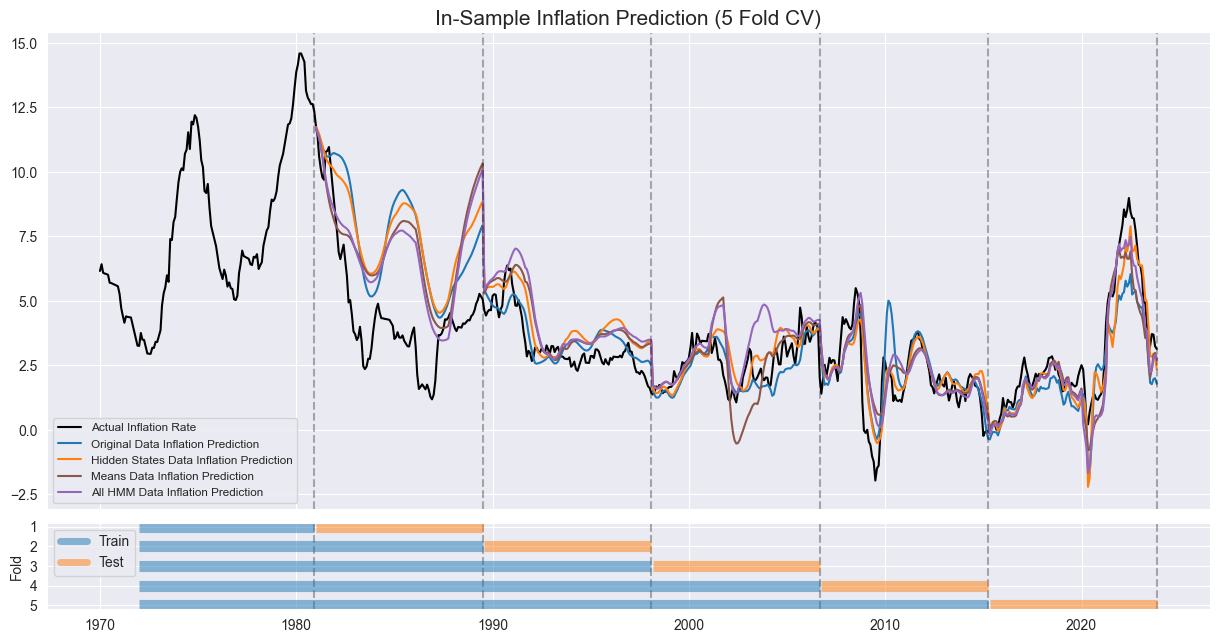

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7.5), gridspec_kw={'height_ratios': [11, 2]}, 
                               sharex=True, dpi=100)
ax1.plot(main_df.index, main_df['inflation_rate'], color='black', label='Actual Inflation Rate')
ax1.plot(in_sample_forecasts_cv_df['date'], in_sample_forecasts_cv_df['original_data_fc'],
         color='C0', label='Original Data Inflation Prediction')
ax1.plot(in_sample_forecasts_cv_df['date'], in_sample_forecasts_cv_df['hidden_data_fc'],
         color='C1', label='Hidden States Data Inflation Prediction')
ax1.plot(in_sample_forecasts_cv_df['date'], in_sample_forecasts_cv_df['means_data_fc'],
         color='C5', label='Means Data Inflation Prediction')
ax1.plot(in_sample_forecasts_cv_df['date'], in_sample_forecasts_cv_df['all_hmm_data_fc'],
         color='C4', label='All HMM Data Inflation Prediction')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.set_title('In-Sample Inflation Prediction (5 Fold CV)')

ax1.axvline(df.index[train_idxs[0][-1] + time_steps], linestyle='dashed', color='black', alpha=0.3)
ax2.axvline(df.index[train_idxs[0][-1] + time_steps], linestyle='dashed', color='black', alpha=0.3)

for i in range(len(test_idxs)):
    ax1.axvline(x=df.index[test_idxs[i][-1] + time_steps], linestyle='dashed', color='black', alpha=0.3)
    ax2.axvline(x=df.index[test_idxs[i][-1] + time_steps], linestyle='dashed', color='black', alpha=0.3)

for i, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
    for idx, color in zip([train_idx, test_idx], ['C0', 'C1']):
        start = df.index[idx[0] + time_steps]
        end = df.index[idx[-1] + time_steps]
        ax2.hlines(y=5-i, xmin=start, xmax=end, color=color, alpha=0.5, linewidth=8.0)

ax2.set_ylabel('Fold')
ax2.set_yticks(range(1, 6))
ax2.set_yticklabels([str(i) for i in range(5, 0, -1)], fontsize=10, horizontalalignment='right')
plt.subplots_adjust(hspace=0.05)

train_handle = Line2D([0], [0], color='C0', alpha=0.5, linewidth=5.0, label='Train')
test_handle = Line2D([0], [0], color='C1', alpha=0.5, linewidth=5.0, label='Test')
ax1.legend(prop={'size': 8.5})
ax2.legend(handles=[train_handle, test_handle])

plt.show()

## Out of Sample Forecast

In [42]:
out_df_list = [main_df, hidden_hmm_df, means_hmm_df, all_hmm_df]
out_title_list = ['Original Data', 'Hidden States Data', 'Means Data', 'All HMM Data']

out_of_sample_lists_1 = []
out_of_sample_lists_25 = []

n_forecast_1 = 12
n_lookback_1 = 48

n_forecast_25 = 30
n_lookback_25 = 120

new_inflation_rates = {dt.datetime(2023, 12, 1): 3.32316, 
                       dt.datetime(2024, 1, 1): 3.10598,
                       dt.datetime(2024, 2, 1): 3.16574,
                       dt.datetime(2024, 3, 1): 3.47513}

spf_inflation_rates = {dt.datetime(2024, 1, 1): 2.5, 
                       dt.datetime(2024, 4, 1): 2.5,
                       dt.datetime(2024, 7, 1): 2.4,
                       dt.datetime(2024, 10, 1): 2.4,
                       dt.datetime(2025, 1, 1): 2.3}

umich_inflation_rates = {dt.datetime(2023, 12, 1): 3.1, 
                         dt.datetime(2024, 1, 1): 2.9,
                         dt.datetime(2024, 2, 1): 3.0}

In [43]:
forecast_methods = ['original_forecast', 'hidden_forecast', 'means_forecast', 'all_hmm_forecast']
colors = ['C0', 'C1', 'C5', 'C4']
curve_labels = ['Original Data', 'Hidden States Data', 'Means Data', 'All HMM Data']

### 1 Year Forecast

In [44]:
tf.keras.utils.set_random_seed(42)

os_X_11, os_Y_11, os_y_11, \
os_X_features_11, scaler_os_y_11 = data_processor.os_data_preprocess(out_df_list[0].copy(), 
                                                                     target_variable, 
                                                                     n_lookback_1,
                                                                     n_forecast_1)

os_model_11 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_11')

os_X_11_ = np.hstack((os_y_11[-n_lookback_1:], os_X_features_11[-n_lookback_1:]))
os_X_11_ = os_X_11_.reshape(1, n_lookback_1, os_X_11_.shape[1])

os_Y_11_ = os_model_11.predict(os_X_11_).reshape(-1, 1)
os_Y_11_ = scaler_os_y_11.inverse_transform(os_Y_11_)

os_Y_11_std = np.std(os_model_11.predict(os_X_11), axis=0)
upper_bound_11 = os_Y_11_ + 1.96 * os_Y_11_std
lower_bound_11 = os_Y_11_ - 1.96 * os_Y_11_std

results_11 =  data_processor.forecast_dataset_creator(out_df_list[0].copy(), 
                                                      os_Y_11_, 
                                                      upper_bound_11,
                                                      lower_bound_11,
                                                      n_forecast_1)
out_of_sample_lists_1.append(results_11)

print("Dataframe results complete")

19/19 [==============================] - 0s 4ms/step
Dataframe results complete


In [45]:
tf.keras.utils.set_random_seed(42)

os_X_12, os_Y_12, os_y_12, \
os_X_features_12, scaler_os_y_12 = data_processor.os_data_preprocess(out_df_list[1].copy(), 
                                                                     target_variable, 
                                                                     n_lookback_1, 
                                                                     n_forecast_1)

os_model_12 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_12')

os_X_12_ = np.hstack((os_y_12[-n_lookback_1:], os_X_features_12[-n_lookback_1:]))
os_X_12_ = os_X_12_.reshape(1, n_lookback_1, os_X_12_.shape[1])

os_Y_12_ = os_model_12.predict(os_X_12_).reshape(-1, 1)
os_Y_12_ = scaler_os_y_12.inverse_transform(os_Y_12_)

os_Y_12_std = np.std(os_model_12.predict(os_X_12), axis=0)
upper_bound_12 = os_Y_12_ + 1.96 * os_Y_12_std
lower_bound_12 = os_Y_12_ - 1.96 * os_Y_12_std

results_12 =  data_processor.forecast_dataset_creator(out_df_list[1].copy(),
                                                      os_Y_12_,
                                                      upper_bound_12,
                                                      lower_bound_12,
                                                      n_forecast_1)
out_of_sample_lists_1.append(results_12)

print("Dataframe results complete")

19/19 [==============================] - 0s 4ms/step
Dataframe results complete


In [46]:
tf.keras.utils.set_random_seed(42)

os_X_13, os_Y_13, os_y_13, \
os_X_features_13, scaler_os_y_13 = data_processor.os_data_preprocess(out_df_list[2].copy(), 
                                                                     target_variable, 
                                                                     n_lookback_1, 
                                                                     n_forecast_1)

os_model_13 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_13')

os_X_13_ = np.hstack((os_y_13[-n_lookback_1:], os_X_features_13[-n_lookback_1:]))
os_X_13_ = os_X_13_.reshape(1, n_lookback_1, os_X_13_.shape[1])

os_Y_13_ = os_model_13.predict(os_X_13_).reshape(-1, 1)
os_Y_13_ = scaler_os_y_13.inverse_transform(os_Y_13_)

os_Y_13_std = np.std(os_model_13.predict(os_X_13), axis=0)
upper_bound_13 = os_Y_13_ + 1.96 * os_Y_13_std
lower_bound_13 = os_Y_13_ - 1.96 * os_Y_13_std

results_13 =  data_processor.forecast_dataset_creator(out_df_list[2].copy(),
                                                      os_Y_13_,
                                                      upper_bound_13,
                                                      lower_bound_13,
                                                      n_forecast_1)
out_of_sample_lists_1.append(results_13)

print("Dataframe results complete")

19/19 [==============================] - 0s 4ms/step
Dataframe results complete


In [47]:
tf.keras.utils.set_random_seed(42)

os_X_14, os_Y_14, os_y_14, \
os_X_features_14, scaler_os_y_14 = data_processor.os_data_preprocess(out_df_list[3].copy(), 
                                                                     target_variable, 
                                                                     n_lookback_1, 
                                                                     n_forecast_1)

os_model_14 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_14')

os_X_14_ = np.hstack((os_y_14[-n_lookback_1:], os_X_features_14[-n_lookback_1:]))
os_X_14_ = os_X_14_.reshape(1, n_lookback_1, os_X_14_.shape[1])

os_Y_14_ = os_model_14.predict(os_X_14_).reshape(-1, 1)
os_Y_14_ = scaler_os_y_14.inverse_transform(os_Y_14_)

os_Y_14_std = np.std(os_model_14.predict(os_X_14), axis=0)
upper_bound_14 = os_Y_14_ + 1.96 * os_Y_14_std
lower_bound_14 = os_Y_14_ - 1.96 * os_Y_14_std

results_14 =  data_processor.forecast_dataset_creator(out_df_list[3].copy(), 
                                                      os_Y_14_, 
                                                      upper_bound_14, 
                                                      lower_bound_14, 
                                                      n_forecast_1)
out_of_sample_lists_1.append(results_14)

print("Dataframe results complete")

19/19 [==============================] - 0s 4ms/step
Dataframe results complete


In [48]:
forecast_1_df = data_processor.forecast_dataset_cleaner(out_of_sample_lists_1, hmm_model, n_forecast_1)

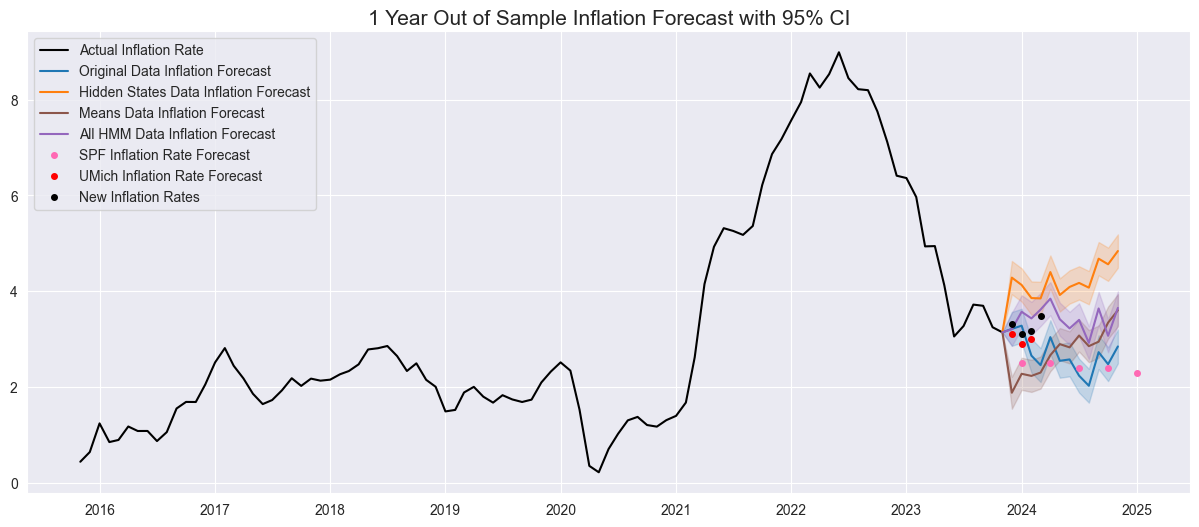

In [49]:
plt.figure(figsize = (15, 6), dpi=100)
plt.plot(forecast_1_df['actual_rate'][550:], color='black', label='Actual Inflation Rate')

for fm_1, c_1, cl_1 in zip(forecast_methods, colors, curve_labels):
    plt.plot(forecast_1_df[fm_1], color=c_1, label=f'{cl_1} Inflation Forecast')
    plt.fill_between(forecast_1_df.index, forecast_1_df[f'{fm_1}_l'], 
                     forecast_1_df[f'{fm_1}_u'], color=c_1, alpha=0.2)

plt.plot(spf_inflation_rates.keys(), spf_inflation_rates.values(), marker='o', 
         markersize=4, linestyle='', color='hotpink', label='SPF Inflation Rate Forecast')

plt.plot(umich_inflation_rates.keys(), umich_inflation_rates.values(), marker='o', 
         markersize=4, linestyle='', color='red', label='UMich Inflation Rate Forecast')

plt.plot(new_inflation_rates.keys(), new_inflation_rates.values(), marker='o', 
         markersize=4, linestyle='', color='black', label='New Inflation Rates')

plt.title("1 Year Out of Sample Inflation Forecast with 95% CI")
plt.legend()
plt.show()

In [50]:
feature_importance_11 = np.load(f'Models/integrated_gradients/feature_importance_os_11.npy')
feature_importance_11_scaled = 1000 * feature_importance_11

feature_importance_12 = np.load(f'Models/integrated_gradients/feature_importance_os_12.npy')
feature_importance_12_scaled = 1000 * feature_importance_12

feature_importance_13 = np.load(f'Models/integrated_gradients/feature_importance_os_13.npy')
feature_importance_13_scaled = 1000 * feature_importance_13

feature_importance_14 = np.load(f'Models/integrated_gradients/feature_importance_os_14.npy')
feature_importance_14_scaled = 1000 * feature_importance_14

feature_importances_os_1 = [feature_importance_11_scaled, feature_importance_12_scaled,
                            feature_importance_13_scaled, feature_importance_14_scaled]

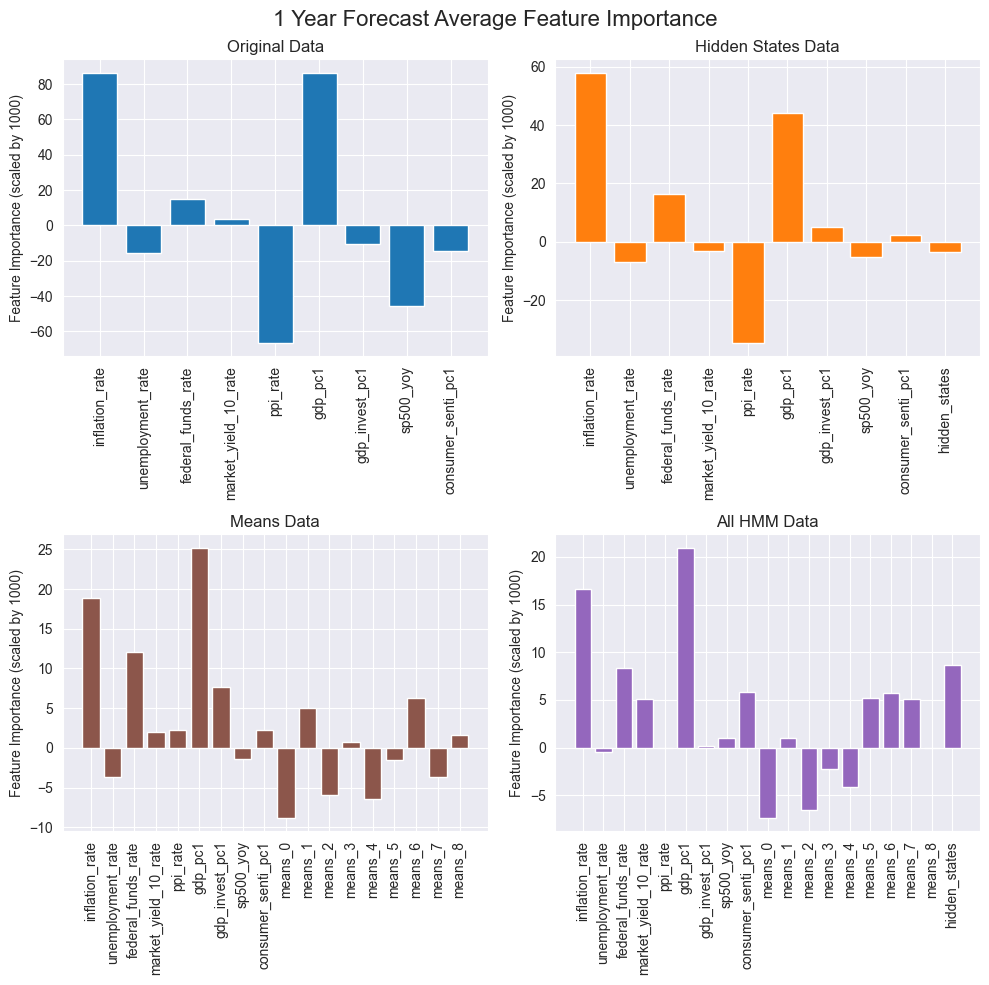

In [51]:
plt.figure(figsize=(10, 10), dpi=100)
for i, (feature_importances, out_df, title, cl) in enumerate(zip(feature_importances_os_1, out_df_list, out_title_list, colors), 1):
    plt.subplot(2, 2, i)
    plt.bar(range(len(feature_importances)), feature_importances, color=cl)
    plt.xticks(range(len(feature_importances)), out_df.columns, rotation=90)
    plt.ylabel("Feature Importance (scaled by 1000)")
    plt.title(f"{title}", fontsize=12)

plt.suptitle('1 Year Forecast Average Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()

### 2.5 Year Forecast

In [52]:
tf.keras.utils.set_random_seed(42)

os_X_251, os_Y_251, os_y_251, \
os_X_features_251, scaler_os_y_251 = data_processor.os_data_preprocess(out_df_list[0].copy(), 
                                                                       target_variable, 
                                                                       n_lookback_25,
                                                                       n_forecast_25)

os_model_251 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_251')

os_X_251_ = np.hstack((os_y_251[-n_lookback_25:], os_X_features_251[-n_lookback_25:]))
os_X_251_ = os_X_251_.reshape(1, n_lookback_25, os_X_251_.shape[1])

os_Y_251_ = os_model_251.predict(os_X_251_).reshape(-1, 1)
os_Y_251_ = scaler_os_y_251.inverse_transform(os_Y_251_)

os_Y_251_std = np.std(os_model_251.predict(os_X_251), axis=0)
upper_bound_251 = os_Y_251_ + 1.96 * os_Y_251_std
lower_bound_251 = os_Y_251_ - 1.96 * os_Y_251_std

results_251 =  data_processor.forecast_dataset_creator(out_df_list[0].copy(), 
                                                       os_Y_251_,
                                                       upper_bound_251, 
                                                       lower_bound_251, 
                                                       n_forecast_25)
out_of_sample_lists_25.append(results_251)

print("Dataframe results complete")

16/16 [==============================] - 0s 10ms/step
Dataframe results complete


In [53]:
tf.keras.utils.set_random_seed(42)

os_X_252, os_Y_252, os_y_252, \
os_X_features_252, scaler_os_y_252 = data_processor.os_data_preprocess(out_df_list[1].copy(), 
                                                                       target_variable, 
                                                                       n_lookback_25, 
                                                                       n_forecast_25)

os_model_252 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_252')

os_X_252_ = np.hstack((os_y_252[-n_lookback_25:], os_X_features_252[-n_lookback_25:]))
os_X_252_ = os_X_252_.reshape(1, n_lookback_25, os_X_252_.shape[1])

os_Y_252_ = os_model_252.predict(os_X_252_).reshape(-1, 1)
os_Y_252_ = scaler_os_y_252.inverse_transform(os_Y_252_)

os_Y_252_std = np.std(os_model_252.predict(os_X_252), axis=0)
upper_bound_252 = os_Y_252_ + 1.96 * os_Y_252_std
lower_bound_252 = os_Y_252_ - 1.96 * os_Y_252_std

results_252 =  data_processor.forecast_dataset_creator(out_df_list[1].copy(), 
                                                       os_Y_252_, 
                                                       upper_bound_252, 
                                                       lower_bound_252, 
                                                       n_forecast_25)
out_of_sample_lists_25.append(results_252)

print("Dataframe results complete")

16/16 [==============================] - 0s 10ms/step
Dataframe results complete


In [54]:
tf.keras.utils.set_random_seed(42)

os_X_253, os_Y_253, os_y_253, \
os_X_features_253, scaler_os_y_253 = data_processor.os_data_preprocess(out_df_list[2].copy(), 
                                                                       target_variable, 
                                                                       n_lookback_25, 
                                                                       n_forecast_25)

os_model_253 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_253')

os_X_253_ = np.hstack((os_y_253[-n_lookback_25:], os_X_features_253[-n_lookback_25:]))
os_X_253_ = os_X_253_.reshape(1, n_lookback_25, os_X_253_.shape[1])

os_Y_253_ = os_model_253.predict(os_X_253_).reshape(-1, 1)
os_Y_253_ = scaler_os_y_253.inverse_transform(os_Y_253_)

os_Y_253_std = np.std(os_model_253.predict(os_X_253), axis=0)
upper_bound_253 = os_Y_253_ + 1.96 * os_Y_253_std
lower_bound_253 = os_Y_253_ - 1.96 * os_Y_253_std

results_253 =  data_processor.forecast_dataset_creator(out_df_list[2].copy(), 
                                                       os_Y_253_, 
                                                       upper_bound_253, 
                                                       lower_bound_253, 
                                                       n_forecast_25)
out_of_sample_lists_25.append(results_253)

print("Dataframe results complete")

16/16 [==============================] - 0s 10ms/step
Dataframe results complete


In [55]:
tf.keras.utils.set_random_seed(42)

os_X_254, os_Y_254, os_y_254, \
os_X_features_254, scaler_os_y_254 = data_processor.os_data_preprocess(out_df_list[3].copy(), 
                                                                       target_variable, 
                                                                       n_lookback_25, 
                                                                       n_forecast_25)

os_model_254 = tf.keras.models.load_model(f'Models/out_sample_forecasts/os_model_254')

os_X_254_ = np.hstack((os_y_254[-n_lookback_25:], os_X_features_254[-n_lookback_25:]))
os_X_254_ = os_X_254_.reshape(1, n_lookback_25, os_X_254_.shape[1])

os_Y_254_ = os_model_254.predict(os_X_254_).reshape(-1, 1)
os_Y_254_ = scaler_os_y_254.inverse_transform(os_Y_254_)

os_Y_254_std = np.std(os_model_254.predict(os_X_254), axis=0)
upper_bound_254 = os_Y_254_ + 1.96 * os_Y_254_std
lower_bound_254 = os_Y_254_ - 1.96 * os_Y_254_std

results_254 =  data_processor.forecast_dataset_creator(out_df_list[3].copy(), 
                                                       os_Y_254_, 
                                                       upper_bound_254, 
                                                       lower_bound_254, 
                                                       n_forecast_25)
out_of_sample_lists_25.append(results_254)

print("Dataframe results complete")

16/16 [==============================] - 0s 10ms/step
Dataframe results complete


In [56]:
forecast_25_df = data_processor.forecast_dataset_cleaner(out_of_sample_lists_25, hmm_model, n_forecast_25)

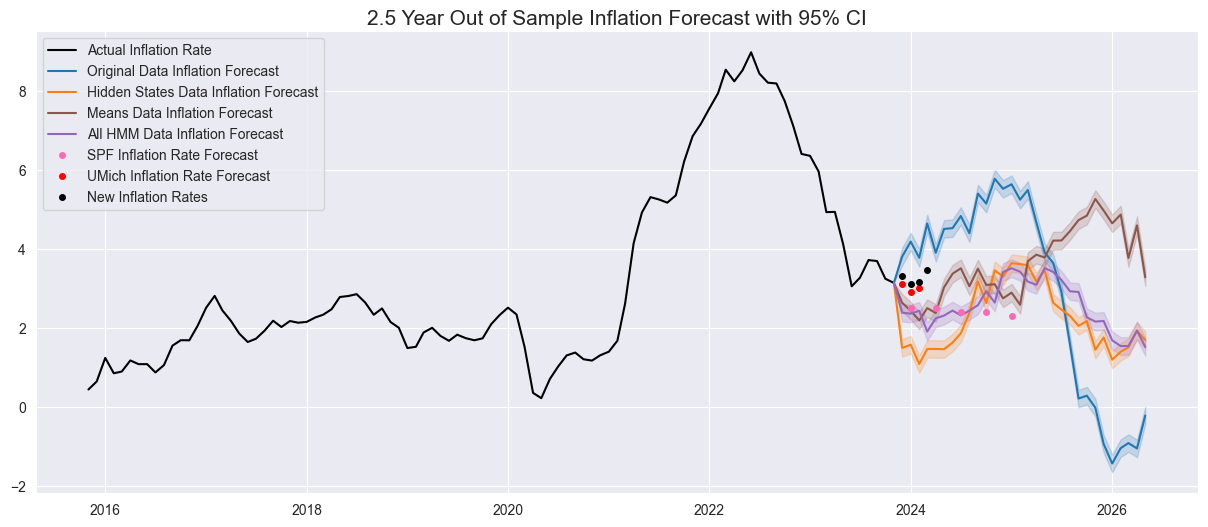

In [57]:
plt.figure(figsize = (15, 6), dpi=100)
plt.plot(forecast_25_df['actual_rate'][550:], color='black', label='Actual Inflation Rate')

for fm_25, c_25, cl_25 in zip(forecast_methods, colors, curve_labels):
    plt.plot(forecast_25_df[fm_25], color=c_25, label=f'{cl_25} Inflation Forecast')
    plt.fill_between(forecast_25_df.index, forecast_25_df[f'{fm_25}_l'], 
                     forecast_25_df[f'{fm_25}_u'], color=c_25, alpha=0.2)

plt.plot(spf_inflation_rates.keys(), spf_inflation_rates.values(), marker='o', 
         markersize=4, linestyle='', color='hotpink', label='SPF Inflation Rate Forecast')

plt.plot(umich_inflation_rates.keys(), umich_inflation_rates.values(), marker='o', 
         markersize=4, linestyle='', color='red', label='UMich Inflation Rate Forecast')

plt.plot(new_inflation_rates.keys(), new_inflation_rates.values(), marker='o', 
         markersize=4, linestyle='', color='black', label='New Inflation Rates')

plt.title("2.5 Year Out of Sample Inflation Forecast with 95% CI")
plt.legend(loc='upper left')
plt.show()

In [58]:
feature_importance_251 = np.load(f'Models/integrated_gradients/feature_importance_os_251.npy')
feature_importance_251_scaled = 1000 * feature_importance_251

feature_importance_252 = np.load(f'Models/integrated_gradients/feature_importance_os_252.npy')
feature_importance_252_scaled = 1000 * feature_importance_252

feature_importance_253 = np.load(f'Models/integrated_gradients/feature_importance_os_253.npy')
feature_importance_253_scaled = 1000 * feature_importance_253

feature_importance_254 = np.load(f'Models/integrated_gradients/feature_importance_os_254.npy')
feature_importance_254_scaled = 1000 * feature_importance_254

feature_importances_os_25 = [feature_importance_251_scaled, feature_importance_252_scaled,
                             feature_importance_253_scaled, feature_importance_254_scaled]

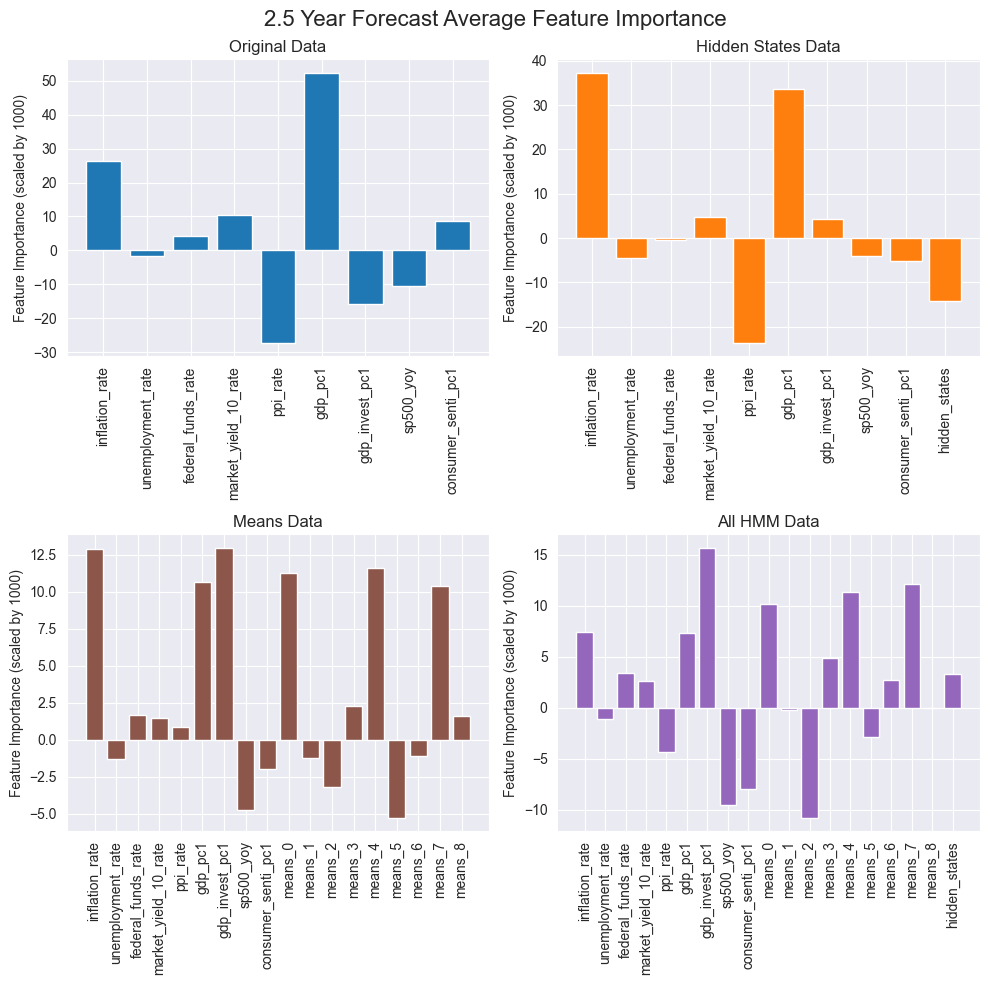

In [59]:
plt.figure(figsize=(10, 10), dpi=100)
for i, (feature_importances, out_df, title, cl) in enumerate(zip(feature_importances_os_25, out_df_list, out_title_list, colors), 1):
    plt.subplot(2, 2, i)
    plt.bar(range(len(feature_importances)), feature_importances, color=cl)
    plt.xticks(range(len(feature_importances)), out_df.columns, rotation=90)
    plt.ylabel("Feature Importance (scaled by 1000)")
    plt.title(f"{title}", fontsize=12)

plt.suptitle('2.5 Year Forecast Average Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()